## Setup Environment

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pathlib
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim

from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm

## Declare Constants

In [3]:
MAX_LEN = 120
NLATENT = 196
DECODER_HIDDEN_SIZE = 488
DECODER_NUM_LAYERS = 3

DATA_DIR = './data'
DATA_FILE_NAME = '250k_rndm_zinc_drugs_clean_3.csv'
CHAR_FILE_NAME = 'zinc.json'
TEST_IDX_FILE_NAME = 'test_idx.npy'

MODELS_DIR = './models'

## Create a Utility Class

In [4]:
class VAEUtils:
    '''
    This purpose of this class is to help with various aspects
    of data processing
    '''
    
    def __init__(self, data_dir=DATA_DIR, 
                 data_file_name=DATA_FILE_NAME, 
                 char_file_name=CHAR_FILE_NAME, 
                 test_idx_file_name=TEST_IDX_FILE_NAME,
                 max_len=MAX_LEN):
        
        self.data_dir = pathlib.Path(data_dir)
        self.data_file = self.data_dir / pathlib.Path(data_file_name)
        self.char_file = self.data_dir / pathlib.Path(char_file_name)
        self.test_file = self.data_dir / pathlib.Path(test_idx_file_name)
        
        self.max_len = max_len
        
        all_letters = yaml.safe_load(open(self.char_file)) + ['SOS']
        self.all_letters = all_letters
        self.n_letters = len(all_letters)
        self.letters_to_indices_dict = dict((l, i) for i, l in enumerate(all_letters))
        self.indices_to_letters_dict = dict((i, l) for i, l in enumerate(all_letters))
               
    def get_data_df(self):
        df = pd.read_csv(self.data_file)
        df = df[df.smiles.str.len() <= self.max_len].reset_index(drop=True)
        
        # preprocess input smile to remove the newline character and add padding
        df.loc[:, 'smiles'] = df.loc[:, 'smiles'].str.strip()\
                    .str.pad(width=self.max_len, side='right', fillchar=" ")
        
        return df
        
    # One-hot matrix of first to last letters (not including EOS) for input
    def get_input_tensor(self, smile):
        tensor = torch.zeros(1, len(smile), self.n_letters) # batch_size * seq_length * num_features
        for i, letter in enumerate(smile):
            tensor[0][i][self.letters_to_indices_dict[letter]] = 1
        return tensor

    # LongTensor of first letter to end (EOS) for target
    def get_target_tensor(self, smile):
        letter_indexes = [self.letters_to_indices_dict[l] for l in smile]
        # letter_indexes.append(self.n_letters - 1) # EOS
        return torch.LongTensor(letter_indexes)
    
    def get_train_valid_test_splits(self, reg_col, valid_pct=.1):
        df = self.get_data_df()[['smiles', reg_col]]
        df = df.rename(columns={reg_col: 'reg_col'})
        
        test_idx = np.load(self.test_file)
        non_test_idx = np.array(df[~df.index.isin(test_idx)].index)
        train_idx, valid_idx = train_test_split(non_test_idx, test_size=valid_pct, 
                                                random_state=42, shuffle=True)
        
        assert len(df) == len(test_idx) + len(train_idx) + len(valid_idx)
        
        return df, train_idx, valid_idx, test_idx
         
    def get_dl(self, df, idx, bs, device, shuffle=False):
        
        df = df.iloc[idx]
        
        input_tensors = torch.zeros(len(df), self.max_len, self.n_letters)
        target_tensors = torch.zeros(len(df), self.max_len, dtype=torch.long)
        for i, smile in tqdm(enumerate(df.smiles)):
            input_tensors[i] = self.get_input_tensor(smile)
            target_tensors[i] = self.get_target_tensor(smile)
        
        input_tensors = input_tensors.to(device)
        target_tensors = target_tensors.to(device)
        
        original_lengths = torch.tensor(df.smiles.str.strip().str.len().to_numpy()).to(device)

        property_values = torch.tensor(df.reg_col.to_numpy()).type(torch.float32).to(device)
         
        ds = TensorDataset(input_tensors, target_tensors, original_lengths, property_values)
        dl = DataLoader(ds, shuffle=shuffle, batch_size=bs)
        
        return dl
    
vae_utils = VAEUtils()

## Create the Model Networks

In [5]:
class Lambda(nn.Module):
    '''
    This class simplifies layers from 
    custom functions
    '''
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)

In [6]:
class Encoder(nn.Module):
    def __init__(self, n_letters, nlatent, decoder_hidden_size):
        super().__init__()
        self.n_letters = n_letters
        self.nlatent = nlatent
        self.decoder_hidden_size = decoder_hidden_size
        self.encoder = nn.Sequential(
            Lambda(lambda x: x.permute(0, 2, 1)), # the features are in the channels dimension
            nn.Conv1d(in_channels=n_letters, out_channels=9, kernel_size=9),
            nn.Tanh(), # the authors of the paper used tanh
            nn.BatchNorm1d(9), # the authors of the paper did batch normalization
            nn.Conv1d(in_channels=9, out_channels=9, kernel_size=9),
            nn.Tanh(), # the authors of the paper used tanh
            nn.BatchNorm1d(9), # the authors of the paper did batch normalization
            nn.Conv1d(in_channels=9, out_channels=11, kernel_size=10),
            nn.Tanh(), # the authors of the paper used tanh
            nn.BatchNorm1d(11), # the authors of the paper did batch normalization
            nn.Flatten()
        )
        
        self.mean = nn.Linear(1045, nlatent)
        self.log_var = nn.Linear(1045, nlatent)
        self.dec_init_hidden = nn.Linear(nlatent, decoder_hidden_size)
        
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var) 
        eps = torch.randn_like(std)
        sample = mean + (eps * std) 
        return sample
        
    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mean, log_var)
        dec_init_hidden = self.dec_init_hidden(z)
        
        return z, mean, log_var, dec_init_hidden

In [7]:
def preprocess_decoder_input(input_tensors):
    '''
    Adjust for SOS and make batch the second demension
    '''
    sos_tensor = torch.zeros(1, vae_utils.n_letters)
    sos_tensor[0][vae_utils.letters_to_indices_dict['SOS']] = 1
    new_tensor = torch.zeros(input_tensors.shape[0], vae_utils.max_len, vae_utils.n_letters)
    new_tensor[:][0] = sos_tensor
    new_tensor[:, 1:vae_utils.max_len, :] = input_tensors[:, 0:vae_utils.max_len-1, :]
    new_tensor = new_tensor.permute(1, 0, 2).to(input_tensors.device)
    
    return new_tensor

In [8]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.preprocess = Lambda(preprocess_decoder_input)
        self.rnn = nn.GRU(input_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, input_size)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, input, hidden):
        output, hidden = self.rnn(self.preprocess(input), )
        output = output.permute(1, 0, 2)
        output = self.softmax(self.out(output))
        return output, hidden

In [9]:
class PropertyPredictor(nn.Module):
    def __init__(self, nlatent):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(nlatent, 1000),
            nn.Tanh(), # the authors of the paper used tanh
            nn.Dropout(.2),
            nn.Linear(1000, 1000),
            nn.Tanh(), # the authors of the paper used tanh
            nn.Dropout(.2),
            nn.Linear(1000, 1)
        )
        
    def forward(self, x):
        return self.predictor(x) 

## Write Helper Functions for Training and Testing

In [10]:
def kl_anneal_function(epoch, anneal_start, k=1):
    return 1 / (1 + np.exp(- k * (epoch - anneal_start)))

In [11]:
def time_since(since):
    now = time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:.0f}s'

In [12]:
def fit(epochs, anneal_start, lr, train_dl, valid_dl, device, reg_col:str, load_previous=False):
    encoder = Encoder(vae_utils.n_letters, NLATENT, DECODER_HIDDEN_SIZE).to(device)
    decoder = Decoder(vae_utils.n_letters, DECODER_HIDDEN_SIZE, DECODER_NUM_LAYERS).to(device)
    property_predictor = PropertyPredictor(NLATENT).to(device)
    
    if load_previous:
        encoder.load_state_dict(torch.load(pathlib.Path(MODELS_DIR, f'{reg_col}_encoder.pth')))
        decoder.load_state_dict(torch.load(pathlib.Path(MODELS_DIR, f'{reg_col}_decoder.pth')))
        property_predictor.load_state_dict(torch.load(pathlib.Path(MODELS_DIR, f'{reg_col}_property_predictor.pth')))
    
    enc_opt = optim.Adam(encoder.parameters(), lr=lr)
    dec_opt = optim.Adam(decoder.parameters(), lr=lr)
    pp_opt = optim.Adam(property_predictor.parameters(), lr=lr)
    
    recontruction_loss_func = nn.NLLLoss()
    reg_loss_func = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    def process_dl(epoch, dl, train:bool):
        num_loaders = len(dl)
        loader_loss = 0
        for input_tensors, target_tensors, original_lengths, property_values in dl:
            z, mean, log_var, dec_init_hidden = encoder(input_tensors)
            output, hidden = decoder(input_tensors, 
                                     dec_init_hidden.unsqueeze(0).repeat(DECODER_NUM_LAYERS, 1, 1))
            reg_pred = property_predictor(z)
            
            kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
            kl_weight = kl_anneal_function(epoch, anneal_start)
            
            reg_loss = reg_loss_func(reg_pred.flatten(), property_values)
            reg_loss = reg_loss.type(torch.float32) 
            
            reconstruction_loss = 0
            for i in range(input_tensors.shape[0]):
                reconstruction_loss += recontruction_loss_func(output[i], target_tensors[i])
            reconstruction_loss /= input_tensors.shape[0]
            reconstruction_loss = reconstruction_loss.type(torch.float32) 

            loss = reconstruction_loss + kl_divergence * kl_weight + reg_loss
            
            if train:
                enc_opt.zero_grad()
                dec_opt.zero_grad()
                pp_opt.zero_grad()
                
                loss.backward()
                
                enc_opt.step()
                dec_opt.step()
                pp_opt.step()
                
            loader_loss += loss.item()
        
        return loader_loss / num_loaders
    
    start_time = time()
    
    for epoch in tqdm(range(epochs)):
        encoder.train()
        decoder.train()
        property_predictor.train()
        train_loss = process_dl(epoch, train_dl, train=True)
        train_losses.append(train_loss)
        
        encoder.eval()
        decoder.eval()
        property_predictor.eval()
        with torch.no_grad():
            val_loss = process_dl(epoch, valid_dl, train=False)
            val_losses.append(val_loss)
            
        print(f"Epoch: {epoch+1:3d} | Train Loss: {train_loss:10.5f} | Val Loss: {val_loss:10.5f} | " +\
              f"Time Taken: {time_since(start_time)}")
    
    models_dir = pathlib.Path(MODELS_DIR)
    models_dir.mkdir(exist_ok=True, parents=True)
    torch.save(encoder.state_dict(), models_dir / pathlib.Path(f'{reg_col}_encoder.pth'))
    torch.save(decoder.state_dict(), models_dir / pathlib.Path(f'{reg_col}_decoder.pth'))
    torch.save(property_predictor.state_dict(), models_dir / pathlib.Path(f'{reg_col}_property_predictor.pth'))
    
    return train_losses, val_losses

In [13]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 15})

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label = 'Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.show()

In [14]:
def get_dataloaders(df, train_idx, valid_idx, test_idx):
    start_time = time()
    train_dl = vae_utils.get_dl(df, train_idx[:max_samples], bs, device, shuffle=True)
    valid_dl = vae_utils.get_dl(df, valid_idx[:max_samples], bs*2, device)
    test_dl = vae_utils.get_dl(df, test_idx[:max_samples], bs*2, device)
    print(f'Time taken to get dataloaders: {time() - start_time:.2f}s')
    
    return train_dl, valid_dl, test_dl

In [15]:
def get_pred_mae(reg_col, dl):
    encoder = Encoder(vae_utils.n_letters, NLATENT, DECODER_HIDDEN_SIZE).to(device)
    property_predictor = PropertyPredictor(NLATENT).to(device)

    encoder.load_state_dict(torch.load(pathlib.Path(MODELS_DIR, f'{reg_col}_encoder.pth')))
    property_predictor.load_state_dict(torch.load(pathlib.Path(MODELS_DIR, f'{reg_col}_property_predictor.pth')))
    
    encoder.eval()
    property_predictor.eval()
    
    with torch.no_grad():
        abs_errors = []
        for input_tensors, target_tensors, original_lengths, property_values in dl:
            z, mean, log_var, dec_init_hidden = encoder(input_tensors)
            reg_pred = property_predictor(z)
            abs_error = torch.abs(property_values - reg_pred.flatten())
            abs_errors.append(abs_error)
            
        abs_errors = torch.cat(abs_errors)
        mae_error = abs_errors.mean()
        
    return mae_error

## Define Parameters for Training

In [16]:
valid_pct = .1
bs = 1000
max_samples = 250000
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
epochs = 15
anneal_start = 5
lr = 0.0005
load_previous = True

## Train and Test the Network for _logP_

In [17]:
errors = {}

224018it [04:17, 869.46it/s]
24891it [00:28, 860.76it/s]
546it [00:00, 759.91it/s]
  0%|          | 0/15 [00:00<?, ?it/s]

Time taken to get dataloaders: 291.81s


  7%|▋         | 1/15 [03:29<48:50, 209.32s/it]

Epoch:   1 | Train Loss:    1.25938 | Val Loss:    1.27215 | Time Taken: 3m 29s


 13%|█▎        | 2/15 [06:59<45:24, 209.59s/it]

Epoch:   2 | Train Loss:    1.26588 | Val Loss:    1.28007 | Time Taken: 6m 59s


 20%|██        | 3/15 [10:28<41:55, 209.65s/it]

Epoch:   3 | Train Loss:    1.27078 | Val Loss:    1.27260 | Time Taken: 10m 29s


 27%|██▋       | 4/15 [13:58<38:27, 209.82s/it]

Epoch:   4 | Train Loss:    1.26427 | Val Loss:    1.29715 | Time Taken: 13m 59s


 33%|███▎      | 5/15 [17:28<34:57, 209.79s/it]

Epoch:   5 | Train Loss:    1.26756 | Val Loss:    1.30843 | Time Taken: 17m 29s


 40%|████      | 6/15 [20:58<31:29, 209.91s/it]

Epoch:   6 | Train Loss:    1.27719 | Val Loss:    1.27638 | Time Taken: 20m 59s


 47%|████▋     | 7/15 [24:28<27:59, 209.91s/it]

Epoch:   7 | Train Loss:    1.26608 | Val Loss:    1.27088 | Time Taken: 24m 29s


 53%|█████▎    | 8/15 [27:58<24:29, 209.93s/it]

Epoch:   8 | Train Loss:    1.26412 | Val Loss:    1.28022 | Time Taken: 27m 59s


 60%|██████    | 9/15 [31:28<20:59, 209.85s/it]

Epoch:   9 | Train Loss:    1.26718 | Val Loss:    1.27411 | Time Taken: 31m 28s


 67%|██████▋   | 10/15 [34:58<17:29, 209.89s/it]

Epoch:  10 | Train Loss:    1.26834 | Val Loss:    1.27211 | Time Taken: 34m 58s


 73%|███████▎  | 11/15 [38:29<14:01, 210.28s/it]

Epoch:  11 | Train Loss:    1.26172 | Val Loss:    1.28514 | Time Taken: 38m 29s


 80%|████████  | 12/15 [42:00<10:31, 210.48s/it]

Epoch:  12 | Train Loss:    1.26230 | Val Loss:    1.27470 | Time Taken: 42m 0s


 87%|████████▋ | 13/15 [45:33<07:02, 211.15s/it]

Epoch:  13 | Train Loss:    1.26015 | Val Loss:    1.27967 | Time Taken: 45m 33s


 93%|█████████▎| 14/15 [49:03<03:31, 211.02s/it]

Epoch:  14 | Train Loss:    1.26118 | Val Loss:    1.31450 | Time Taken: 49m 4s


100%|██████████| 15/15 [52:34<00:00, 210.32s/it]

Epoch:  15 | Train Loss:    1.26542 | Val Loss:    1.29547 | Time Taken: 52m 35s


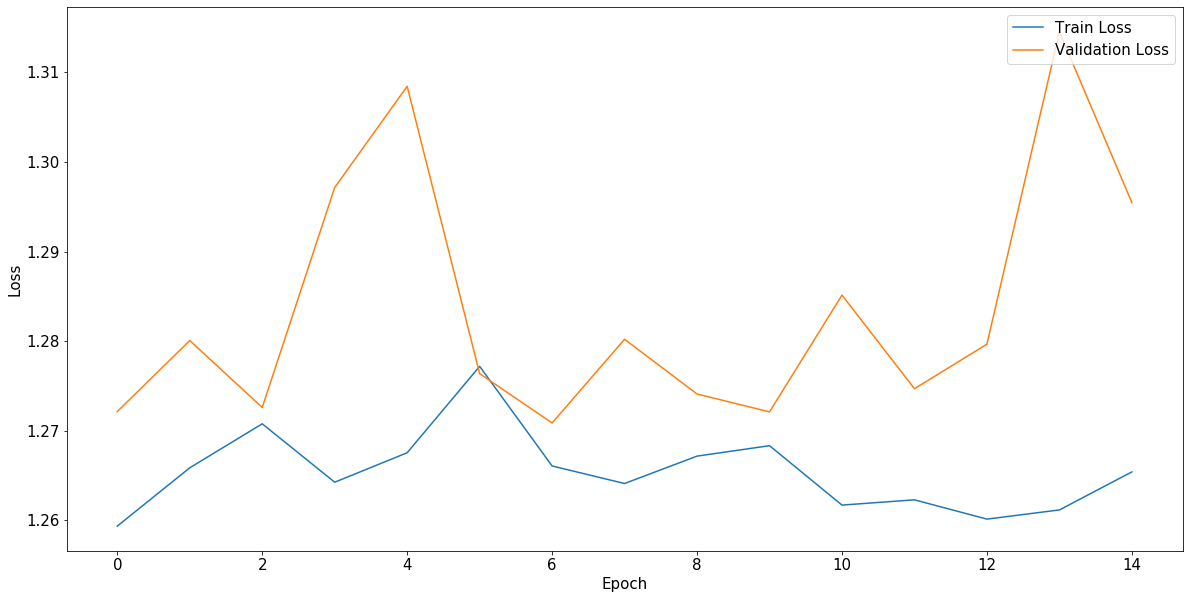

In [18]:
reg_col = 'logP'
df, train_idx, valid_idx, test_idx = vae_utils.get_train_valid_test_splits(reg_col, valid_pct)
train_dl, valid_dl, test_dl = get_dataloaders(df, train_idx, valid_idx, test_idx)
train_losses, val_losses = fit(epochs, anneal_start, lr, train_dl, valid_dl, device, reg_col, load_previous)
plot_losses(train_losses, val_losses)

In [19]:
reg_mean_train = df.iloc[train_idx].reg_col.mean()
mean_mae_test = np.mean(np.abs(df.iloc[test_idx].reg_col - reg_mean_train))
vae_mae_test = get_pred_mae(reg_col, test_dl).item()
errors[reg_col] = {'mean_mae_test': mean_mae_test, 'vae_mae_test': vae_mae_test}

## Train and Test the Network for _QED_

224018it [04:34, 816.05it/s]
24891it [00:31, 797.52it/s]
546it [00:00, 886.34it/s]
  0%|          | 0/15 [00:00<?, ?it/s]

Time taken to get dataloaders: 308.24s


  7%|▋         | 1/15 [03:29<48:48, 209.18s/it]

Epoch:   1 | Train Loss:   -0.86341 | Val Loss:   -0.86314 | Time Taken: 3m 29s


 13%|█▎        | 2/15 [06:59<45:25, 209.68s/it]

Epoch:   2 | Train Loss:   -0.86406 | Val Loss:   -0.86295 | Time Taken: 6m 59s


 20%|██        | 3/15 [10:29<41:58, 209.86s/it]

Epoch:   3 | Train Loss:   -0.86139 | Val Loss:   -0.86188 | Time Taken: 10m 29s


 27%|██▋       | 4/15 [13:59<38:28, 209.83s/it]

Epoch:   4 | Train Loss:   -0.86425 | Val Loss:   -0.86331 | Time Taken: 13m 59s


 33%|███▎      | 5/15 [17:30<35:04, 210.43s/it]

Epoch:   5 | Train Loss:   -0.85489 | Val Loss:   -0.86270 | Time Taken: 17m 31s


 40%|████      | 6/15 [21:01<31:35, 210.57s/it]

Epoch:   6 | Train Loss:   -0.86443 | Val Loss:   -0.86352 | Time Taken: 21m 1s


 47%|████▋     | 7/15 [24:31<28:04, 210.57s/it]

Epoch:   7 | Train Loss:   -0.86472 | Val Loss:   -0.86242 | Time Taken: 24m 32s


 53%|█████▎    | 8/15 [28:02<24:33, 210.45s/it]

Epoch:   8 | Train Loss:   -0.86467 | Val Loss:   -0.86341 | Time Taken: 28m 2s


 60%|██████    | 9/15 [31:32<21:01, 210.31s/it]

Epoch:   9 | Train Loss:   -0.86494 | Val Loss:   -0.86273 | Time Taken: 31m 32s


 67%|██████▋   | 10/15 [35:02<17:31, 210.24s/it]

Epoch:  10 | Train Loss:   -0.86489 | Val Loss:   -0.86326 | Time Taken: 35m 2s


 73%|███████▎  | 11/15 [38:32<14:00, 210.15s/it]

Epoch:  11 | Train Loss:   -0.86500 | Val Loss:   -0.86362 | Time Taken: 38m 32s


 80%|████████  | 12/15 [42:02<10:30, 210.07s/it]

Epoch:  12 | Train Loss:   -0.86531 | Val Loss:   -0.86349 | Time Taken: 42m 2s


 87%|████████▋ | 13/15 [45:31<06:59, 209.95s/it]

Epoch:  13 | Train Loss:   -0.86555 | Val Loss:   -0.86421 | Time Taken: 45m 32s


 93%|█████████▎| 14/15 [49:01<03:29, 209.95s/it]

Epoch:  14 | Train Loss:   -0.86551 | Val Loss:   -0.85965 | Time Taken: 49m 2s


100%|██████████| 15/15 [52:31<00:00, 210.12s/it]

Epoch:  15 | Train Loss:   -0.86516 | Val Loss:   -0.86334 | Time Taken: 52m 32s


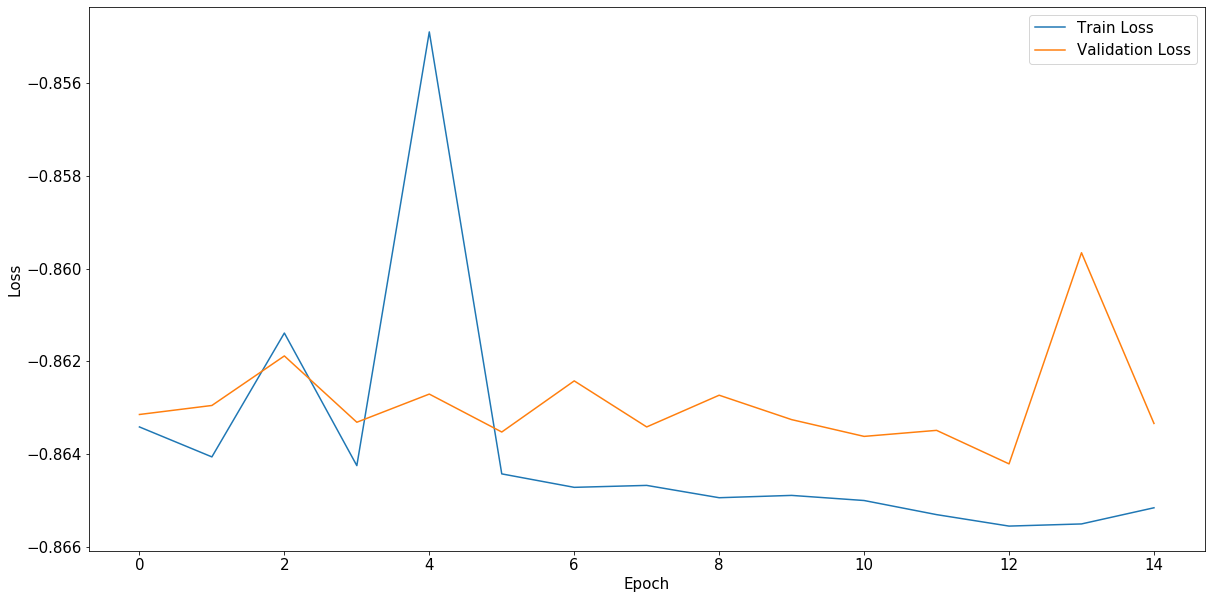

In [20]:
reg_col = 'qed'
df, train_idx, valid_idx, test_idx = vae_utils.get_train_valid_test_splits(reg_col, valid_pct)
train_dl, valid_dl, test_dl = get_dataloaders(df, train_idx, valid_idx, test_idx)
train_losses, val_losses = fit(epochs, anneal_start, lr, train_dl, valid_dl, device, reg_col, load_previous)
plot_losses(train_losses, val_losses)

In [21]:
reg_mean_train = df.iloc[train_idx].reg_col.mean()
mean_mae_test = np.mean(np.abs(df.iloc[test_idx].reg_col - reg_mean_train))
vae_mae_test = get_pred_mae(reg_col, test_dl).item()
errors[reg_col] = {'mean_mae_test': mean_mae_test, 'vae_mae_test': vae_mae_test}

## Report the Results

In [22]:
pd.DataFrame(errors).transpose()

,mean_mae_test,vae_mae_test
logP,1.119256,1.155864
qed,0.107472,0.108098


## Remarks

The model was trained in 4 stages. Except for the 1st stage, the other two stages were trained after loading the saving parameters from the previous stage.
The stages are summarized below:

1. max_exmaples = 20,000, epochs = 50, anneal_start = 15, load_previous = False, bs = 200
2. max_examples = 100,000, epochs = 15, anneal_start = 5, load_previous = True, bs = 200
3. max_examples = all, epochs = 10, anneal_start = 3, load_previous = True, bs = 200
4. max_examples = all, epochs = 15, anneal_start = 5, load_previous = True, bs = 1000
